# This notebook uses Transfer Learning for Eye Open/Closed Classification

- Leverages a pre-trained ResNet18 model for feature extraction
- Applies data augmentation with Pytorch transforms
- Implements early stopping and learning rate scheduling
- Includes advanced visualization with GRAD CAM for model interpretability


## Setup and Imports


In [1]:
import os
import sys
import cv2
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time
import json
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import confusion_matrix, roc_curve, auc
from loguru import logger

torch.manual_seed(1105086)
np.random.seed(1105086)
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {dev}")

2025-05-04 23:02:01.977 | INFO     | __main__:<module>:24 - Using device: cpu


## Configure Loguru


In [2]:
logger.remove()  # Remove default handler
logger.add(
    "../logs/eye_classification_{time}.log",
    rotation="500 MB",
    level="INFO",
    format="{time:YYYY-MM-DD HH:mm:ss} | {level: <8} | {message}",
    backtrace=True,
    diagnose=True,
)
logger.add(sys.stderr, level="INFO")

2

## Defining dataset path and output model path


In [3]:
BASE_DIR = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(BASE_DIR, "inputs/datasets/eyes_data")
MODEL_DIR = os.path.join(BASE_DIR, "models/resnet/")
os.makedirs(MODEL_DIR, exist_ok=True)

## Dataset class defined as follows


In [4]:
class EyesDataset(Dataset):
    def __init__(self, img_paths, lbls, tfm=None):
        self.img_paths = img_paths
        self.lbls = lbls
        self.tfm = tfm

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")
        lbl = self.lbls[idx]

        if self.tfm:
            img = self.tfm(img)

        return img, lbl

## Model Architecture Definition


In [5]:
class EyesModel(nn.Module):
    def __init__(self, num_classes=2):
        super(EyesModel, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                nn.init.constant_(m.bias, 0)

## Data Prep Functions


In [6]:
def get_train_transforms(img_size=224):
    return transforms.Compose(
        [
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )


def get_val_transforms(img_size=224):
    return transforms.Compose(
        [
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )


def prepare_data(data_dir, batch_size=32, img_size=224):
    train_tfm = get_train_transforms(img_size)
    val_tfm = get_val_transforms(img_size)
    train_open_dir = os.path.join(data_dir, "train", "open eyes")
    train_closed_dir = os.path.join(data_dir, "train", "close eyes")
    test_open_dir = os.path.join(data_dir, "test", "open eyes")
    test_closed_dir = os.path.join(data_dir, "test", "close eyes")

    train_open_paths = [
        os.path.join(train_open_dir, f)
        for f in os.listdir(train_open_dir)
        if f.endswith((".jpg", ".jpeg", ".png"))
    ]
    train_closed_paths = [
        os.path.join(train_closed_dir, f)
        for f in os.listdir(train_closed_dir)
        if f.endswith((".jpg", ".jpeg", ".png"))
    ]
    test_open_paths = [
        os.path.join(test_open_dir, f)
        for f in os.listdir(test_open_dir)
        if f.endswith((".jpg", ".jpeg", ".png"))
    ]
    test_closed_paths = [
        os.path.join(test_closed_dir, f)
        for f in os.listdir(test_closed_dir)
        if f.endswith((".jpg", ".jpeg", ".png"))
    ]

    train_open_lbls = [1] * len(train_open_paths)
    train_closed_lbls = [0] * len(train_closed_paths)
    test_open_lbls = [1] * len(test_open_paths)
    test_closed_lbls = [0] * len(test_closed_paths)

    train_paths = train_open_paths + train_closed_paths
    train_lbls = train_open_lbls + train_closed_lbls
    test_paths = test_open_paths + test_closed_paths
    test_lbls = test_open_lbls + test_closed_lbls

    train_paths, val_paths, train_lbls, val_lbls = train_test_split(
        train_paths, train_lbls, test_size=0.2, random_state=42, stratify=train_lbls
    )

    logger.info(f"Total images: {len(train_paths) + len(val_paths) + len(test_paths)}")
    logger.info(f"Training set: {len(train_paths)} images")
    logger.info(f"Validation set: {len(val_paths)} images")
    logger.info(f"Test set: {len(test_paths)} images")

    train_ds = EyesDataset(train_paths, train_lbls, tfm=train_tfm)
    val_ds = EyesDataset(val_paths, val_lbls, tfm=val_tfm)
    test_ds = EyesDataset(test_paths, test_lbls, tfm=val_tfm)

    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True, num_workers=0
    )
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(
        test_ds, batch_size=batch_size, shuffle=False, num_workers=0
    )

    return train_loader, val_loader, test_loader, train_ds, val_ds, test_ds

## Visualisation Methods


In [7]:
def visualize_samples(data_loader, num_samples=5):
    imgs, lbls = next(iter(data_loader))
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        img = imgs[i].cpu().clone()
        img = img * std[:, None, None] + mean[:, None, None]
        img = img.permute(1, 2, 0).clamp(0, 1).numpy()

        axes[i].imshow(img)
        axes[i].set_title(f"Label: {'Open' if lbls[i] == 1 else 'Closed'}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Accuracy")
    plt.plot(history["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_metrics(all_probs, all_lbls):
    all_preds = [1 if p > 0.5 else 0 for p in all_probs]
    cm = confusion_matrix(all_lbls, all_preds)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()

    classes = ["Closed", "Open"]
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45)
    plt.yticks(ticks, classes)

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j,
                i,
                format(cm[i, j], "d"),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")

    fpr, tpr, _ = roc_curve(all_lbls, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.subplot(1, 2, 2)
    plt.plot(
        fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})"
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

## Model Trainer Class


In [8]:
class ModelTrainer:
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        criterion,
        optim,
        dev,
        best_ckpt_path,
        ckpt_dir="checkpoints",
        sched=None,
    ):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optim = optim
        self.sched = sched
        self.dev = dev
        self.best_ckpt_path = best_ckpt_path
        self.ckpt_dir = ckpt_dir

        self.train_losses = []
        self.val_losses = []
        self.train_acc = []
        self.val_acc = []
        os.makedirs(self.ckpt_dir, exist_ok=True)

    def train(self, num_epochs=10, early_stop_patience=5):
        best_val_loss = float("inf")
        patience_count = 0

        for epoch in range(num_epochs):
            logger.info(f"\nEpoch {epoch + 1}/{num_epochs}")

            # Training phase
            self.model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0

            logger.info("Training:")
            for i, (imgs, lbls) in enumerate(
                tqdm(self.train_loader, desc="Training batches")
            ):
                imgs, lbls = imgs.to(self.dev), lbls.to(self.dev)

                self.optim.zero_grad()
                outputs = self.model(imgs)
                loss = self.criterion(outputs, lbls)
                loss.backward()
                self.optim.step()

                train_loss += loss.item() * imgs.size(0)
                _, preds = torch.max(outputs, 1)
                train_total += lbls.size(0)
                train_correct += (preds == lbls).sum().item()

                if (i + 1) % 50 == 0:
                    mini_batch_acc = (preds == lbls).sum().item() / lbls.size(0)
                    logger.info(
                        f"  Batch {i + 1}/{len(self.train_loader)}: Loss: {loss.item():.4f}, Acc: {mini_batch_acc:.4f}"
                    )

            train_loss = train_loss / len(self.train_loader.dataset)
            train_acc = train_correct / train_total

            self.model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0

            logger.info("Validation:")
            with torch.no_grad():
                for imgs, lbls in tqdm(self.val_loader, desc="Validation batches"):
                    imgs, lbls = imgs.to(self.dev), lbls.to(self.dev)

                    outputs = self.model(imgs)
                    loss = self.criterion(outputs, lbls)

                    val_loss += loss.item() * imgs.size(0)
                    _, preds = torch.max(outputs, 1)
                    val_total += lbls.size(0)
                    val_correct += (preds == lbls).sum().item()

            val_loss = val_loss / len(self.val_loader.dataset)
            val_acc = val_correct / val_total

            self.train_losses.append(train_loss)
            self.train_acc.append(train_acc)
            self.val_losses.append(val_loss)
            self.val_acc.append(val_acc)

            old_lr = self.optim.param_groups[0]["lr"]
            if self.sched:
                self.sched.step(val_loss)
            new_lr = self.optim.param_groups[0]["lr"]
            lr_changed = old_lr != new_lr

            is_best = val_loss < best_val_loss
            if is_best:
                best_val_loss = val_loss
                patience_count = 0
                torch.save(self.model.state_dict(), self.best_ckpt_path)
                logger.success("Best model saved.")
            else:
                patience_count += 1
                if patience_count >= early_stop_patience:
                    logger.warning("Early stopping triggered.")
                    break

            logger.info(f"Epoch {epoch + 1}/{num_epochs} Summary:")
            logger.info(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
            logger.info(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            logger.info(
                f"Learning Rate: {new_lr:.6f}" + (" (reduced)" if lr_changed else "")
            )
            logger.info(f"Best Model: {'Saved (New Best)' if is_best else 'Not Saved'}")

        return {
            "train_loss": self.train_losses,
            "val_loss": self.val_losses,
            "train_acc": self.train_acc,
            "val_acc": self.val_acc,
        }

## Evaluation Functions


In [9]:
def evaluate_model(model, test_loader, dev):
    model = model.to(dev)
    model.eval()

    test_correct = 0
    test_total = 0
    all_probs = []
    all_lbls = []

    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs, lbls = imgs.to(dev), lbls.to(dev)
            outputs = model(imgs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            test_total += lbls.size(0)
            test_correct += (preds == lbls).sum().item()
            all_probs.extend(probs[:, 1].cpu().numpy())
            all_lbls.extend(lbls.cpu().numpy())

    test_acc = test_correct / test_total
    logger.info(f"Test Accuracy: {test_acc:.4f}")

    return test_acc, all_probs, all_lbls


def predict_image(model, image_path, transform, dev):
    img = Image.open(image_path).convert("RGB")
    img_t = transform(img).unsqueeze(0).to(dev)
    model.eval()
    with torch.no_grad():
        output = model(img_t)
        probs = torch.nn.functional.softmax(output, dim=1)
        prob = probs[0][1].item()

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"Prediction: {'Open' if prob > 0.5 else 'Closed'} ({prob:.2f})")
    plt.axis("off")
    plt.show()

    return prob

## GRADCAM Visualisation


In [10]:
def grad_cam(
    model,
    image_path,
    transform,
    target_layer="backbone.layer4",
    dev=torch.device("cpu"),
):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(dev)

    activations = None
    gradients = None

    def forward_hook(module, input, output):
        nonlocal activations
        activations = output

    def backward_hook(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0]

    for name, module in model.named_modules():
        if name == target_layer:
            module.register_forward_hook(forward_hook)
            module.register_backward_hook(backward_hook)
            break
    else:
        raise ValueError(f"Layer '{target_layer}' not found in the model.")

    output = model(img_tensor)
    pred_class = output.argmax(dim=1).item()

    model.zero_grad()
    output[0, pred_class].backward()

    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    for i in range(activations.shape[1]):
        activations[0, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations[0], dim=0).cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8
    heatmap = cv2.resize(heatmap, (img.width, img.height))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    img_np = np.array(img)
    if img_np.max() <= 1.0:
        img_np = (img_np * 255).astype(np.uint8)

    superimposed_img = cv2.addWeighted(img_np, 0.6, heatmap_color, 0.4, 0)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap="jet")
    plt.title("Heatmap")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM Prediction: {'Open' if pred_class == 1 else 'Closed'}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

## Running full pipeline

I added comments to make it easier to follow


2025-05-04 23:02:02.097 | INFO     | __main__:<module>:3 - Starting training pipeline at 23:02:02
2025-05-04 23:02:02.099 | INFO     | __main__:<module>:4 - ==================================================
2025-05-04 23:02:02.103 | INFO     | __main__:<module>:8 - Using data directory: /Users/tobylowe/final_drowsiness_detection/eyes_data
2025-05-04 23:02:02.106 | INFO     | __main__:<module>:17 - 
Step 1: Loading and preparing dataset
2025-05-04 23:02:02.107 | INFO     | __main__:<module>:18 - - Batch size: 32
2025-05-04 23:02:02.110 | INFO     | __main__:<module>:19 - - Image resize target: 224x224
2025-05-04 23:02:02.988 | INFO     | __main__:prepare_data:45 - Total images: 84898
2025-05-04 23:02:02.989 | INFO     | __main__:prepare_data:46 - Training set: 65340 images
2025-05-04 23:02:02.989 | INFO     | __main__:prepare_data:47 - Validation set: 16335 images
2025-05-04 23:02:02.990 | INFO     | __main__:prepare_data:48 - Test set: 3223 images
2025-05-04 23:02:02.992 | INFO     | 

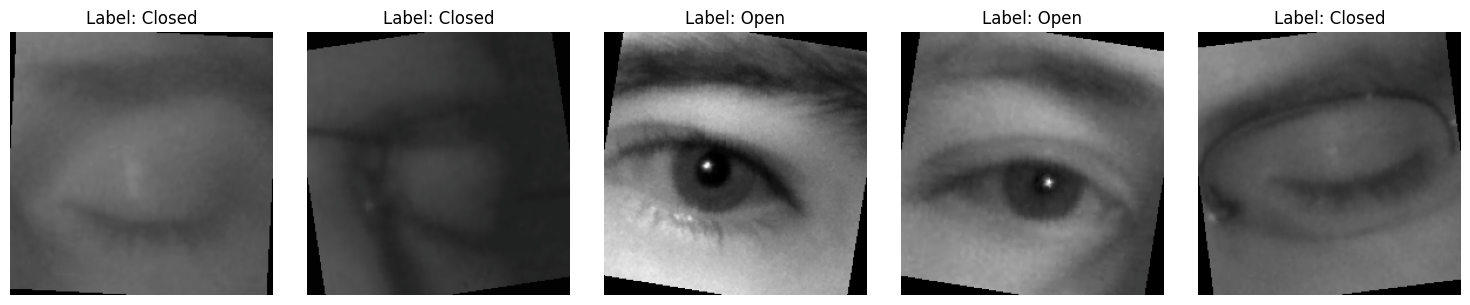

2025-05-04 23:02:03.262 | INFO     | __main__:<module>:30 - 
Step 3: Initializing ResNet-18 model...
/Users/tobylowe/final_drowsiness_detection/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tobylowe/final_drowsiness_detection/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
2025-05-04 23:02:03.476 | INFO     | __main__:<module>:33 - - Model initialization completed in 0.21 seconds
2025-05-04 23:02:03.478 | INFO     | __main__:<module>:34 - - Model parameters: 11,177,538


AttributeError: 'Adam' object has no attribute 'lr_scheduler'

In [ ]:
start_time = time.time()
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
logger.info(f"Starting training pipeline at {time.strftime('%H:%M:%S')}")
logger.info("=" * 50)

notebook_dir = os.getcwd()
data_dir = DATA_DIR
logger.info(f"Using data directory: {data_dir}")

# Hyperparameters
batch_size = 32
img_size = 224
num_epochs = 15
learning_rate = 0.001
early_stop_patience = 5

logger.info("\nStep 1: Loading and preparing dataset")
logger.info(f"- Batch size: {batch_size}")
logger.info(f"- Image resize target: {img_size}x{img_size}")

data_start = time.time()
train_loader, val_loader, test_loader, train_ds, val_ds, test_ds = prepare_data(
    data_dir, batch_size=batch_size, img_size=img_size
)
logger.info(f"- Data preparation completed in {(time.time() - data_start):.2f} seconds")

logger.info("\nStep 2: Visualizing sample images...")
visualize_samples(train_loader, num_samples=5)

logger.info("\nStep 3: Initializing ResNet-18 model...")
model_start = time.time()
model = EyesModel(num_classes=2).to(dev)
logger.info(
    f"- Model initialization completed in {(time.time() - model_start):.2f} seconds"
)
logger.info(f"- Model parameters: {sum(p.numel() for p in model.parameters()):,}")
logger.info(str(model))

logger.info("\nStep 4: Setting up training components")
criterion = nn.CrossEntropyLoss()
optim = optim.Adam(model.parameters(), lr=learning_rate)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, "min", patience=2, factor=0.5)

# Define checkpoint path
best_ckpt_path = os.path.join(MODEL_DIR, "best_eyes_model.pth")

logger.info("\nStep 5: Starting model training")
logger.info(f"- Number of epochs: {num_epochs}")
logger.info(f"- Learning rate: {learning_rate}")
logger.info(f"- Early stopping patience: {early_stop_patience}")

# Create trainer
trainer = ModelTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optim=optim,
    dev=dev,
    ckpt_dir=MODEL_DIR,
    best_ckpt_path=best_ckpt_path,
    sched=sched,
)

# Train model
train_start = time.time()
history = trainer.train(num_epochs=num_epochs, early_stop_patience=early_stop_patience)
train_time = time.time() - train_start
logger.info(
    f"- Training completed in {train_time:.2f} seconds ({train_time / 60:.2f} minutes)"
)

logger.info("\nStep 6: Plotting training history")
plot_training_history(history)

logger.info("\nStep 7: Loading the best model and evaluating on test set")
model.load_state_dict(torch.load(best_ckpt_path))
logger.info("- Best model loaded successfully")

test_start = time.time()
test_acc, all_probs, all_lbls = evaluate_model(model, test_loader, dev)
logger.info(f"- Evaluation completed in {(time.time() - test_start):.2f} seconds")
logger.info(f"- Final test accuracy: {test_acc:.4f}")

logger.info("\nStep 8: Getting metrics and visualizing results")
plot_metrics(all_probs, all_lbls)

logger.info("\nStep 9: Saving final model and summary info")
# Save the final model checkpoint with all information
final_ckpt_path = os.path.join(MODEL_DIR, f"eyes_model_final_{timestamp}.pth")
torch.save(
    {
        "model_state": model.state_dict(),
        "optim_state": optim.state_dict(),
        "sched_state": sched.state_dict(),
        "train_losses": trainer.train_losses,
        "val_losses": trainer.val_losses,
        "train_acc": trainer.train_acc,
        "val_acc": trainer.val_acc,
    },
    final_ckpt_path,
)
logger.success(f"Final model saved to {final_ckpt_path}")

# Create summary dictionary
summary = {
    "dataset_size": {
        "train": len(train_ds),
        "validation": len(val_ds),
        "test": len(test_ds),
    },
    "hyperparameters": {
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "epochs": num_epochs,
        "image_size": img_size,
    },
    "performance": {
        "final_train_acc": trainer.train_acc[-1],
        "final_val_acc": trainer.val_acc[-1],
        "test_acc": test_acc,
    },
}

summary_path = os.path.join(MODEL_DIR, f"training_summary_{timestamp}.json")
try:
    with open(summary_path, "w") as f:
        json.dump(summary, f, indent=4)
    logger.success(f"Summary saved to {summary_path}")
except Exception as e:
    logger.error(f"Could not save summary to file: {e}")

logger.info("\nModel training summary:")
logger.info(
    f"- Dataset: {summary['dataset_size']['train']} training, {summary['dataset_size']['validation']} validation, {summary['dataset_size']['test']} test images"
)
logger.info(
    f"- Final training accuracy: {summary['performance']['final_train_acc']:.4f}"
)
logger.info(
    f"- Final validation accuracy: {summary['performance']['final_val_acc']:.4f}"
)
logger.info(f"- Test accuracy: {summary['performance']['test_acc']:.4f}")

total_time = time.time() - start_time
logger.info(f"\nEnding at: {time.strftime('%H:%M:%S')}")
logger.info(f"Total time: {total_time:.2f} seconds ({total_time / 60:.2f} minutes)")


## Sample Prediction/Visualisation of some images (mostly to support in disseratation)


In [ ]:
def visualise_preds(model, test_ds, num_samples=3):
    indices = np.random.choice(len(test_ds), num_samples, replace=False)
    val_tfm = get_val_transforms()

    for idx in indices:
        img_path, true_lbl = test_ds.img_paths[idx], test_ds.lbls[idx]
        prob = predict_image(model, img_path, val_tfm, dev)
        logger.info(
            f"Image: {os.path.basename(img_path)}, True: {'Open' if true_lbl == 1 else 'Closed'}, Predicted: {'Open' if prob > 0.5 else 'Closed'} ({prob:.3f})"
        )

        # Visualize with Grad-CAM
        try:
            grad_cam(model, img_path, val_tfm, dev=dev)
        except Exception as e:
            logger.error(f"Error generating GRAD CAM: {e}")


logger.info("\nSample predictions with GRADCAM visualization:")
visualise_preds(model, test_ds)